#  NLP Assignment 1: Part A
#  Author  : Pratik Mandlecha
##  Roll Number : 20161172

 
##  Task 1: Tokeniser and Language Model**
###       Implemented: Laplace smoothing, Witten-bell and backoff in class TrigramLanguageModel
###     Complete n-gram is also implemented.

## Task 2: Spell checker**
###      Spell checker is implemented with a tri-gram model for words and alphabets over complete corpus.

## Task 3: Grammaticality test**
###       Uses language model created in Task 1 to give grammatical probabilities of a sentence in various forms.


In [1]:
# imports
import sys
import re
import os
from matplotlib import pyplot as plt
import string
from ipy_table import *
# Plot our findings
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
init_notebook_mode(connected=True)

In [2]:
# Reading Files into text.
text = ""
inputdir = "./Traildata"
filelist = os.listdir(inputdir)
for filename in filelist:
    #print('processing: ', filename)
    with open(inputdir + '/' + filename) as file:
        text+=(file.read())

# Tokenization

## Tokenizing Sentences
1. Took care of End-of-Line Hyphen , Abbrevations , Multiple Newlines, keeping punctuations intact for retaining value in sentence.

2. Handled numbers , URLS , multiple void spaces

## Tokenizing Words
1. Understandable Regex to handle End-of-Line Hyphen , Abbrevations , Spaces , Mathematical equations , url , braces , etc.

2. After Tokenizing into Sentences every sentence is passed through word tokenizer. Thus giving us a sentence-wise word tokenized output

In [3]:
def tokenize_word(text_corp):
    HALF_WORD = re.compile('(-)+(\n)+(-)*'),''
    MULTI_LINES = re.compile('\n'),' '
    SPACES = re.compile('\s{2,}'),' '
    PUNCTUATION = re.compile('[|_-]'),' '
    FULL_STOP = re.compile('(?<![(Mr)(MR)(mr)(Mrs)(MRS)(Dr)(Ms)(i.e)(etc)(\d)(A-Z)])\.'),' '
    PLUS = re.compile('(?<![0-9])\+'),' '
    MINUS = re.compile('(?<![0-9])\-'),' '
    MULTIPLY = re.compile('(?<![0-9])\*'),' '
    DIVIDE = re.compile('(?<![0-9])\/'),' '
    INVERTED = re.compile('\"')," "
    Brackets_1 = re.compile('\[')," "
    Brackets_2 = re.compile('\]')," "
    Brackets_3 = re.compile('\{')," "
    Brackets_4 = re.compile('\}')," "
    Brackets_5 = re.compile('\(')," "
    Brackets_6 = re.compile('\)')," "
    COMMA = re.compile('\,')," "
    Aporstophe = re.compile('(?<=\s)\''),' '
    Aporstophe_last = re.compile('\'(?=\s)'),' '

    SENT_REGEX = [HALF_WORD , MULTI_LINES ,  FULL_STOP , PLUS , MINUS, DIVIDE ,MULTIPLY , Brackets_1,Brackets_2,Brackets_3,
                  Brackets_4,Brackets_5,Brackets_6, INVERTED, COMMA , PUNCTUATION , Aporstophe ,Aporstophe_last, SPACES]
    for regexs, subst in SENT_REGEX:
        text_corp = regexs.sub(subst, text_corp)
    word_tokens = text_corp.split()
    
    #k=0
    #for i in words:
    #    k=k+1
    #    print (k, i)
    return word_tokens

In [4]:
def tokenize_sentence(text_corpus):
    # Given text, tokenise into sentences and words. Take into consideration various delimiters.
    words=[]
    HALF_WORD = re.compile('(-)+(\n)+(-)*'),''
    MULTI_LINES = re.compile('\n'),' '
    SPACES = re.compile('\s+'),' '
    NEW_LINE = re.compile('\n'),' '
    SENT_MAKER = re.compile('(?<=[^A-Z].[.?!]) +(?=[A-Z])'), '-@,'

    SENT_REGEXES = [HALF_WORD , MULTI_LINES , NEW_LINE , SPACES , SENT_MAKER]
    for regex, subs in SENT_REGEXES:
        text_corpus = regex.sub(subs, text_corpus)
    sent_tokens = text_corpus.split('-@,')
    for i in sent_tokens:
        words.append(tokenize_word(i))
    #k=0
    #for sentence in sent_tokens:
    #    k=k+1
     #   print(k,  sentence)
    return words

## Above Sentence Tokenizer on a challenging Input

In [5]:
HALF_WORD = re.compile('(-)+(\n)+(-)*'),''
MULTI_LINES = re.compile('\n{2,}'),'-@,'
NEW_LINE = re.compile('\n'),' '
SPACES = re.compile('\s+'),' '
SENT_MAKER = re.compile('(?<=[^A-Z].[.?!]) +(?=[A-Z])'), '-@,'


texts = """Mr. Smith bought cheapsite.com for 1.5 million dollars, i.e. he paid a lot for it. Did he mind? Adam Jones Jr.
thinks he didn't. In any case, this isn't true... Well, with a probability of .9 it isn't.

PLA-
-Y WITH M-
-E

www.google.com is                                    at your services.

98.99  etc. i.e. J.K.L.M Naganathan is a man. Isn't he?
1,000,000 Rs. is a huge amount, isn't it? Yes it is.

J.K.S.D.F Rowling@gmail.com

It's  a big amo-
-unt
Hi hello how . are you? I am fine.
We will pla-
y today         . COOL ! """

SENT_REGEXES = [HALF_WORD , MULTI_LINES , NEW_LINE , SPACES, SENT_MAKER]
for regex, subs in SENT_REGEXES:
    texts = regex.sub(subs, texts)
m = texts.split('-@,')

k=0
for i in m:
    k=k+1
    print (k, i)

1 Mr. Smith bought cheapsite.com for 1.5 million dollars, i.e. he paid a lot for it.
2 Did he mind?
3 Adam Jones Jr. thinks he didn't.
4 In any case, this isn't true...
5 Well, with a probability of .9 it isn't.
6 PLAY WITH ME
7 www.google.com is at your services.
8 98.99 etc. i.e.
9 J.K.L.M Naganathan is a man.
10 Isn't he? 1,000,000 Rs. is a huge amount, isn't it?
11 Yes it is.
12 J.K.S.D.F Rowling@gmail.com
13 It's a big amount Hi hello how . are you?
14 I am fine.
15 We will play today .
16 COOL ! 


In [6]:
# Gives list of all tokenized corpus

#corpus_words=tokenize_word(text)

# Language Model 
## Tri-gram Model


In [7]:
# Input - List of Tokenized words
# Output - tokens with keys as words and corresponding unigram frequency
def token_counts(words):
    tokens={}
    for token in words:
        #print(token)
        for i in token:
            if i not in tokens:
                tokens[i] = 0
            tokens[i] += 1
    return tokens

In [8]:
tokens = token_counts(tokenize_sentence(text))
sorted_tokens = sorted(tokens.items(), key = lambda x: x[1], reverse=True)

In [9]:
sorted_tokens = sorted_tokens[:100]
make_table(sorted_tokens)

the,59378
of,42596
and,29572
to,24543
in,18465
a,16408
that,13183
is,9715
I,9156
it,8028
as,8012


In [10]:
iplot([{"x" : list(zip(*sorted_tokens))[0], "y": list(zip(*sorted_tokens))[1]}])

In [11]:
# Returns tri-grams and bi-grams from data here being used for complete corpus.

def get_trigrams(wholedata):
    trigrams = {}
    Words = tokenize_sentence(wholedata)
    for words in Words:
        for index in range(len(words)-2):
            pair = (words[index],words[index + 1], words[index + 2])
            if pair not in trigrams:
                trigrams[pair] =0
            trigrams[pair] += 1
    return trigrams


def get_bigrams(wholedata):
    bigrams = {}
    Words = tokenize_sentence(wholedata)
    for words in Words:
        for index in range(len(words)-1):
            pair = (words[index],words[index + 1])
            if pair not in bigrams:
                bigrams[pair] =0
            bigrams[pair] += 1
    return bigrams

In [12]:
trigrams = get_trigrams(text)
bigrams = get_bigrams(text)

In [13]:
sorted_bigrams = sorted(bigrams.items(), key = lambda x: x[1], reverse=True)
sorted_trigrams = sorted(trigrams.items(), key = lambda x: x[1], reverse=True)

In [14]:
top10_bigrams = sorted_bigrams[:10]
top10_trigrams = sorted_trigrams[:10]
bottom10_bigrams = sorted_bigrams[-10:]
bottom10_trigrams = sorted_trigrams[-10:]
print(top10_bigrams)
print(top10_trigrams)
print(bottom10_bigrams)
print(bottom10_trigrams)
sorted_trigrams = sorted_trigrams[:100]
sorted_bigrams = sorted_bigrams[:100]

[(('of', 'the'), 12095), (('in', 'the'), 5167), (('to', 'the'), 3884), (('and', 'the'), 2300), (('to', 'be'), 2075), (('on', 'the'), 1926), (('that', 'the'), 1759), (('by', 'the'), 1616), (('it', 'is'), 1486), (('of', 'a'), 1420)]
[(('the', 'United', 'States'), 378), (('of', 'the', 'United'), 326), (('as', 'well', 'as'), 306), (('part', 'of', 'the'), 298), (('one', 'of', 'the'), 297), (('I', 'do', 'not'), 250), (('that', 'it', 'is'), 214), (('some', 'of', 'the'), 193), (('the', 'people', 'of'), 188), (('of', 'the', 'same'), 184)]
[(('occur', 'being'), 1), (('bed', 'humble'), 1), (('these', 'antagonistic'), 1), (('Lines', '374'), 1), (('doubt', 'Mr.'), 1), (('and', 'main'), 1), (('therefore', 'although'), 1), (('flying', 'frog'), 1), (('for', 'eating'), 1), (('evil', 'smelling'), 1)]
[(('meadows', 'of', 'Sweden'), 1), (('go', 'with', 'these.'), 1), (('been', 'in', 'such'), 1), (('or', 'by', 'indirection'), 1), (('11.', 'Treron', 'sieboldi.'), 1), (('the', 'chair', 'on'), 1), (('themselv

In [15]:
make_table(top10_bigrams)

"('of', 'the')",12095
"('in', 'the')",5167
"('to', 'the')",3884
"('and', 'the')",2300
"('to', 'be')",2075
"('on', 'the')",1926
"('that', 'the')",1759
"('by', 'the')",1616
"('it', 'is')",1486
"('of', 'a')",1420


In [16]:
make_table(top10_trigrams)

"('the', 'United', 'States')",378
"('of', 'the', 'United')",326
"('as', 'well', 'as')",306
"('part', 'of', 'the')",298
"('one', 'of', 'the')",297
"('I', 'do', 'not')",250
"('that', 'it', 'is')",214
"('some', 'of', 'the')",193
"('the', 'people', 'of')",188
"('of', 'the', 'same')",184


In [17]:
make_table(bottom10_bigrams)

"('occur', 'being')",1
"('bed', 'humble')",1
"('these', 'antagonistic')",1
"('Lines', '374')",1
"('doubt', 'Mr.')",1
"('and', 'main')",1
"('therefore', 'although')",1
"('flying', 'frog')",1
"('for', 'eating')",1
"('evil', 'smelling')",1


In [18]:
make_table(bottom10_trigrams)

"('meadows', 'of', 'Sweden')",1
"('go', 'with', 'these.')",1
"('been', 'in', 'such')",1
"('or', 'by', 'indirection')",1
"('11.', 'Treron', 'sieboldi.')",1
"('the', 'chair', 'on')",1
"('themselves', 'often', 'it')",1
"('loses', 'something', 'of')",1
"('proportionately', 'much', 'longer')",1
"('quite', 'happy', 'that')",1


In [19]:
# Sorted trigram with frequency Graph
iplot([{"x" : ['_'.join(x) for x in list(zip(*sorted_trigrams))[0]], "y": list(zip(*sorted_trigrams))[1]}])

In [20]:
#iplot([{"x" : ['_'.join(x) for x in list(zip(*sorted_trigrams))[0]], "y": list(log(log(zip(*sorted_trigrams))[1]))}])

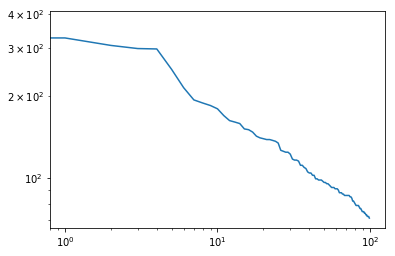

In [21]:
x_1 = []
y_1 = []
for i in sorted_trigrams:
    x_1.append(i[0])
    y_1.append(i[1])
plt.loglog(range(len(y_1)), y_1)      

## Probabilities and Smoothing

### Trigram Probability Calculation

In [22]:
# Computes probability of a trigram (a,b,c) i.e. P(c|a,b)/P(a,b).
def probability_computer(tri_tup):
    bi_tup = (tri_tup[0],tri_tup[1])
    try :
        bi=float(bigrams[bi_tup])
        tri=float(trigrams[tri_tup])
        return (tri/bi)
    except Exception as e:
        return 0


In [23]:
probability_computer(('of', 'the', 'various'))

0.0028937577511368336

### Bigram Probability Calculation

In [24]:
def probability_computer_bi(bi_tup):
    uni_tup = (bi_tup[0])
    try :
        uni=float(tokens[uni_tup])
        bi=float(bigrams[bi_tup])
        return (bi/uni)
    except Exception as e:
        return 0

In [25]:
probability_computer_bi(('of', 'the'))

0.28394684946943377

### Laplace Smoothing

In [26]:
def laplace_smoothing(tri_tup):
    bi_tup = (tri_tup[0],tri_tup[1])
    try :
        bi=float(bigrams[bi_tup])
    except: bi = 0
    try:
        tri=float(trigrams[tri_tup])
    except: tri = 0
    
    l = len(trigrams) # Number of different Trigrams in complete Corpus.
    return ((tri+1)/(bi+l))

In [27]:
laplace_smoothing(('of', 'the', 'various'))

5.5063215630611475e-05

### Witten Bell Smoothing

In [28]:
def witten_bell(tri_tup):
    bi_tup = (tri_tup[0],tri_tup[1])
    try :
        bi=float(bigrams[bi_tup])
    except: bi = 0
    try:
        tri=float(trigrams[tri_tup])
    except: tri = 0
    try:
        uni=float(tokens[tri_tup[0]])
    except: uni = 0
        
        
    tri_keys=trigrams.keys()
    bi_count = 0
    uni_count = 0
    for i in tri_keys:
        if i[0] == bi_tup[0] and i[1] == bi_tup[1]:
            bi_count += 1.0
    for i in tokens:
        if i[0] == bi_tup[0]:
            uni_count += 1.0
            
    lamb = 1 - uni_count/(uni_count + bi_count)
    p = lamb*tri/bi +(1-lamb) * bi/uni
    return p

In [29]:
witten_bell(('of', 'the', 'various'))

0.0028937577511368336

## Complete N-gram

In [30]:
def complete_ngram(bi_tup, n):
    tri_keys=trigrams.keys()
    words = {}
    
    for i in tri_keys:
        if i[0] == bi_tup[0] and i[1] == bi_tup[1]:
            words[i[2]] = trigrams[i]
    sorted_complete = sorted(words.items(), key = lambda x: x[1], reverse=True)
    return words

In [31]:
words=complete_ngram(('of', 'the'),3)

In [32]:
make_table(sorted(words.items(), key = lambda x: x[1], reverse=True))

United,326
same,184
most,136
country,134
people,122
whole,116
great,111
world,104
Union,102
species,97
Constitution,91


### Deleted Interpolation

In [33]:
def deleted_interpolation(tri_tup):
    y1 = 0.45
    y2 = 0.35
    y3 = 0.2
    bi_tup = (tri_tup[0],tri_tup[1])
    try :
        bi=float(bigrams[bi_tup])
    except: bi = 0
    try:
        tri=float(trigrams[tri_tup])
    except: tri = 0
    try:
        uni=float(tokens[tri_tup[0]])
    except: uni = 0
    return ((y1*(tri/bi))+(y2*(bi/uni))+y3*(uni/len(tokens)))

In [34]:
deleted_interpolation(('of', 'the', 'various'))

0.28668013874660747

# Spelling Correction

In [35]:
def plot_ngram_freqs(ngrams):
# Calculate unigram frequencies and plot them in the descending order of frequency
# Example code for using plotly to plot frequencies
    import plotly.plotly as py
    import plotly.graph_objs as go

    # Add data
    month = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
             'August', 'September', 'October', 'November', 'December']
    high_2014 = [28.8, 28.5, 37.0, 56.8, 69.7, 79.7, 78.5, 77.8, 74.1, 62.6, 45.3, 39.9]

    # Create and style traces
    trace0 = go.Scatter(
        x = month,
        y = high_2014,
        name = 'High 2014',
        line = dict(
            color = ('rgb(205, 12, 24)'),
            width = 4)
    )
    
    data = [trace0]

    # Edit the layout
    layout = dict(title = 'Average High and Low Temperatures in New York',
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Temperature (degrees F)'),
                  )

    fig = dict(data=data, layout=layout)
    py.iplot(fig, filename='styled-line')

## Language Model for Spell Checker.

In [36]:
# Gives the set of all trigram alphabet sets over the corpus.
def get_alp_trigrams_sentence(W_data):
    alp_trigrams = {}
    words_set = tokenize_sentence(W_data)
    for word in words_set:
        for alphabet in word:
            #print(alphabet[0])
            for index in range(len(alphabet)-2):
                #print(alphabet[index])
                alp_pair = (alphabet[index],alphabet[index + 1], alphabet[index + 2])
                if alp_pair not in alp_trigrams:
                    alp_trigrams[alp_pair] =0
                alp_trigrams[alp_pair] += 1
    return alp_trigrams

In [37]:
# Gives the set of all biigram alphabet sets over the corpus.
def get_alp_bigrams_sentence(W_data):
    alp_bigrams = {}
    words_set = tokenize_sentence(W_data)
    for word in words_set:
        for alphabet in word:
            #print(alphabet[0])
            for index in range(len(alphabet)-1):
                #print(alphabet[index])
                alp_pair = (alphabet[index],alphabet[index + 1])
                if alp_pair not in alp_bigrams:
                    alp_bigrams[alp_pair] =0
                alp_bigrams[alp_pair] += 1
    return alp_bigrams

In [38]:
alp_tri_sen = get_alp_trigrams_sentence(text)

In [39]:
sorted_tri = sorted(alp_tri_sen.items(), key = lambda x: x[1], reverse=True)
top20_sorted_tri = sorted_tri[:20]
make_table(top20_sorted_tri)

"('t', 'h', 'e')",81866
"('a', 'n', 'd')",36134
"('i', 'n', 'g')",22518
"('i', 'o', 'n')",21837
"('t', 'i', 'o')",17577
"('h', 'a', 't')",15981
"('t', 'h', 'a')",15526
"('e', 'n', 't')",15389
"('h', 'e', 'r')",14566
"('e', 'r', 'e')",12589
"('v', 'e', 'r')",11761


In [40]:
alp_bi_sen = get_alp_bigrams_sentence(text)

In [41]:
sorted_bi = sorted(alp_bi_sen.items(), key = lambda x: x[1], reverse=True)
top20_sorted_bi = sorted_bi[:1000]
make_table(top20_sorted_bi)

"('t', 'h')",123561
"('h', 'e')",105682
"('i', 'n')",74392
"('a', 'n')",70427
"('e', 'r')",68517
"('r', 'e')",61799
"('o', 'n')",55281
"('n', 'd')",51890
"('a', 't')",50026
"('e', 'n')",46679
"('e', 's')",45708


In [42]:
alp_bi_sen['o','f']

44898

In [43]:
def get_alp_trigrams(W_data):
    alp_trigrams = {}
    for index in range(len(W_data)-2):
        alp_pair = (W_data[index],W_data[index + 1], W_data[index + 2])
        if alp_pair not in alp_trigrams:
            alp_trigrams[alp_pair] =0
        alp_trigrams[alp_pair] += 1
    return alp_trigrams

In [44]:
get_alp_trigrams('United')

{('U', 'n', 'i'): 1,
 ('i', 't', 'e'): 1,
 ('n', 'i', 't'): 1,
 ('t', 'e', 'd'): 1}

In [45]:
def get_alp_bigrams(W_data):
    alp_bigrams = {}
    for index in range(len(W_data)-1):
        alp_pair = (W_data[index],W_data[index + 1])
        if alp_pair not in alp_bigrams:
            alp_bigrams[alp_pair] =0
        alp_bigrams[alp_pair] += 1
    return alp_bigrams

In [46]:
get_alp_bigrams('United')

{('U', 'n'): 1, ('e', 'd'): 1, ('i', 't'): 1, ('n', 'i'): 1, ('t', 'e'): 1}

In [47]:
def word_pro(word):    
    p=0
    tri_tup = get_alp_trigrams(word)
    #print('tri', tri_tup)
    for i in tri_tup.keys():
        bi_tup_1 = (i[0],i[1])
        bi_tup_2 = (i[1],i[2])
        #print('bi', bi_tup_1 , bi_tup_2 )
        try :
            bi=float(alp_bi_sen[bi_tup_1])
        except: bi = 0
        try:
            tri=float(alp_tri_sen[i])
        except: tri = 0
        #print(tri,bi)
        #print('p', p)
        p+= ((tri+1)/(len(alp_tri_sen)+1))

    return p

Here It is not the probability but it calculates properly how possible it is to come for a word properly.

In [48]:
word_pro('ate')

0.7926455566905005

In [49]:
def string_changer(word,ind,replacement):
    new_word = word[:ind]+replacement+word[ind+1:]
    return new_word

In [50]:
string_changer('unhted',2,'i')

'united'

In [51]:
def spell_checker(word):
    probability=word_pro(word)
    #print('initial pro' , probability)
    f_index=0
    ch='i'
    vocabulary = string.ascii_letters
    #if probability > 10e-2:
     #   return word
    for index in range(len(word)):
        for char in vocabulary:
            new_word = string_changer(word , index , char)
            #print(new_word , word_pro(new_word) , word_pro(word) )
            if word_pro(new_word) > probability:
                #print('hi')
                #print(new_word , word_pro(new_word) , word_pro(word) )
                probability = word_pro(new_word)
                f_index=index
                ch = char
                #print('ind , ch' , f_index , char , ch)
    #print('final ind , ch' , f_index , char , ch)            
    word = string_changer(word , f_index , ch )          
    return(word)

In [52]:
spell_checker('thy')

'the'

In [53]:
spell_checker('marn')

'mare'

In [54]:
spell_checker('uniyed')

'united'

# Task 3 : Grammaticality Test
## Computes-
1. Laplace Smoothing
2. Deleted Interpolation
3. Trigram Probability
4. Witten-Bell Probability of a given Sentence

In [55]:
def score_grammaticality(sentence, language_model):

    t=get_trigrams(sentence)
    p_inter=1
    p_laplace=1
    p_normal=1
    p_witten=1
    for i in t:
        p_inter *= deleted_interpolation(i)
        p_laplace *= laplace_smoothing(i)
        p_witten *= witten_bell(i)
        p_normal *= probability_computer(i)
    print('Laplacian Probability -> ', p_laplace)
    print('Witten-Bell Probability -> ', p_witten)
    print('Trigram Probability -> ', p_normal)
    print('Deleted Interpolation Probability -> ', p_inter)
    return { p_inter , p_laplace , p_witten , p_normal}   

In [56]:
score_grammaticality('am of the United States',trigrams)

Laplacian Probability ->  4.60011525862197e-13
Witten-Bell Probability ->  0.0
Trigram Probability ->  0.0
Deleted Interpolation Probability ->  0.0007054421548060277


{0.0, 4.60011525862197e-13, 0.0007054421548060277}